# Battle of the Neighbourhoods: Sushi Edition

This notebook will be used for the IBM Data Science capstone project - 'Battle of the Neighbourhoods'.

## Introduction and Business Problem

In this installment of Battle of the Neighbourhoods, I’m going to be looking at which city I should start a Sushi restaurant in. I’m also going to look at which cities are comparable when it comes to food. This will be based on the density of sushi restaurants compared to all other restaurants.

The cities I’ve chose for this battle are:
* Toronto
* Ottawa
* Montreal
* Vancouver
* New York
* Los Angeles
* San Francisco
* Portland
* Chicago
* Atlanta
* Miami
* Seattle
* Sao Paolo
* London
* Paris
* Berlin
* Tokyo
* Singapore
* Manila
* Bangkok


## Data 

I’ll be accessing restaurants within a 5 kilometer radius of the city centre. With this information, I’ll use this to calculate my sushi density index and the distribution of sushi restaurants based on price. I’ll then look at the five most popular sushi restaurants in the top five sushi cities and access their average rating. From this I’ll calculate an average sushi restaurant score.

This will require two different GET requests from the FourSquare API. The first request will explore venues within 5,000 metres of the city center and be limited to restaurants only. This will get all of the restaurants in the city. This list will be used to calculate sushi density. From this I can filter down only sushi restaurants.

I’ll use the sushi data to draw conclusions on the different cities tastes and where they stand in the world of sushi.

## Methodology

For this analysis, I chose to look at twenty cities across the globe to determine the city that loves their sushi the best. This is determined through the number of sushi restaurants that are popular in each city identified through FourSquare’s explore feature of their venue API. The explore feature allows developers to access top recommended venues in a given geographic location.

In [2]:
import pandas as pd
import numpy as np
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!pip install folium
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### Getting the location data

I created a data frame of the twenty cities that I’m exploring and then looped through the Nominatim function of geopy to find latitudes and longitudes for each city. 

In [3]:
cities = pd.DataFrame({'City':['Toronto', 'Ottawa', 'Montreal', 'Vancouver', 'New York', 'Los Angeles', 'San Francisco',
                              'Portland','Chicago', 'Atlanta', 'Miami', 'Seattle', 'Sao Paolo', 'London', 'Paris',
                               'Berlin', 'Tokyo', 'Singapore', 'Manila', 'Bangkok'],
                       'Latitude':0,'Longitude':0})

for index, row in cities.iterrows():
    geolocator = Nominatim(user_agent="explorer")
    location = geolocator.geocode(row['City'])
    cities.iloc[index,1] = location.latitude
    cities.iloc[index,2] = location.longitude
    
cities

,City,Latitude,Longitude
0,Toronto,43.653482,-79.383935
1,Ottawa,45.421106,-75.690308
2,Montreal,45.497216,-73.610364
3,Vancouver,49.260872,-123.113953
4,New York,40.712728,-74.006015
5,Los Angeles,34.053691,-118.242767
6,San Francisco,37.779026,-122.419906
7,Portland,45.520247,-122.674195
8,Chicago,41.875562,-87.624421
9,Atlanta,33.749099,-84.390185


Using the latitudes and longitudes for each city, I created a map in folium to ensure the geolocator worked correctly and didn’t misplace any cities or use an incorrect city with a similar name – like Paris or London, Ontario, rather than their European/British counterparts). 

In [4]:
map_cities = folium.Map(location=[0,0], zoom_start=2, tiles='CartoDB positron')

# add markers to map
for lat, lng, city in zip(cities['Latitude'], cities['Longitude'], cities['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color='white',
        fill=True,
        fill_color='black',
        fill_opacity=0.7,
        parse_html=False).add_to(map_cities) 

map_cities

### Accessing FourSquare

Once I correctly got the latitudes and longitudes I was able to access the data from the FourSquare API.  FourSquare limits the number of locations for each API call to 100, so I was able to get the top 100 ‘food’ locations. Unfortunately, FourSquare’s API will include a number of things that have been coded as food but are not actually food. For example, in the first five venues returned for Toronto, Only one, Richmond Station, was actually a food venue. The others may serve food (like the snack bar at Nathan Phillips Square) but that is not their primary venue category. This is unfortunate as it limits the number of actual restaurants.

In [5]:
CLIENT_ID = 'H1YPTNIF4ZCK2YFBKXE500MWILVC2WEJNDRGZ14V55HCEHAI' # your Foursquare ID
CLIENT_SECRET = '3XESM3IBMS3S44ZR2YKRLCO23SF2QPHSDJX1PXMOUPRJVDVR' # your Foursquare Secret
VERSION = '20190601' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: H1YPTNIF4ZCK2YFBKXE500MWILVC2WEJNDRGZ14V55HCEHAI
CLIENT_SECRET:3XESM3IBMS3S44ZR2YKRLCO23SF2QPHSDJX1PXMOUPRJVDVR


In [6]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius=5000, category='4bf58dd8d48988d1d2941735', LIMIT=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&subcategory={}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            category,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category Primary']
    
    return(nearby_venues)

In [11]:
restaurants = getNearbyVenues(names=cities['City'],
                                   latitudes=cities['Latitude'],
                                   longitudes=cities['Longitude']
                                  )

Toronto
Ottawa
Montreal
Vancouver
New York
Los Angeles
San Francisco
Portland
Chicago
Atlanta
Miami
Seattle
Sao Paolo
London
Paris
Berlin
Tokyo
Singapore
Manila
Bangkok


In [12]:
print(restaurants.shape)
restaurants.head()

(2000, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category Primary
0,Toronto,43.653482,-79.383935,Downtown Toronto,43.653232,-79.385296,Neighborhood
1,Toronto,43.653482,-79.383935,Nathan Phillips Square,43.652270,-79.383516,Plaza
2,Toronto,43.653482,-79.383935,UNIQLO ユニクロ,43.655910,-79.380641,Clothing Store
3,Toronto,43.653482,-79.383935,Richmond Station,43.651569,-79.379266,American Restaurant
4,Toronto,43.653482,-79.383935,Elgin And Winter Garden Theatres,43.653394,-79.378507,Theater


To remove non-food venues from the list, I filtered on ‘Venue Primary Category’ to only include categories with the term ‘Restaurant’ in it. This reduced my list of 2,000 locations to 327. In those 327 results, there were 71 unique restaurant categories.

In [13]:
restaurants = restaurants[restaurants['Venue Category Primary'].str.contains('Restaurant')].reset_index(drop=True)
print('There are {} uniques categories.'.format(len(restaurants['Venue Category Primary'].unique())))

There are 71 uniques categories.


### Exploring the Tastes of Each City

Using the filtered data, I performed a one hot encoding on the primary category and grouped the data set by city, taking the mean of the data to ascertain the relative shares of each type of popular restaurant by city. 

In [14]:
# one hot encoding
onehot = pd.get_dummies(restaurants[['Venue Category Primary']], prefix="", prefix_sep="")

onehot.insert(column = 'City', value=restaurants['City'],loc=0) 

onehot.groupby('City').mean()


,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Baiano Restaurant,Belgian Restaurant,Brazilian Restaurant,Cajun / Creole Restaurant,Caribbean Restaurant,Caucasian Restaurant,Chinese Restaurant,Cuban Restaurant,Donburi Restaurant,Dumpling Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Filipino Restaurant,French Restaurant,German Restaurant,Greek Restaurant,Hakka Restaurant,Halal Restaurant,Hawaiian Restaurant,Hotpot Restaurant,Indian Restaurant,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Kebab Restaurant,Korean Restaurant,Latin American Restaurant,Lebanese Restaurant,Malay Restaurant,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Modern European Restaurant,Moroccan Restaurant,New American Restaurant,Okonomiyaki Restaurant,Peruvian Restaurant,Portuguese Restaurant,Ramen Restaurant,Restaurant,Russian Restaurant,Scandinavian Restaurant,Seafood Restaurant,Shabu-Shabu Restaurant,Soba Restaurant,Som Tum Restaurant,South American Restaurant,South Indian Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Sukiyaki Restaurant,Sushi Restaurant,Swiss Restaurant,Taiwanese Restaurant,Tapas Restaurant,Tempura Restaurant,Tex-Mex Restaurant,Thai Restaurant,Theme Restaurant,Tonkatsu Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Yakitori Restaurant,Yoshoku Restaurant
City,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Atlanta,0.185185,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.037037,0.037037,0.0,0.000000,0.037037,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000,0.000000,0.000,0.037037,0.000000,0.000000,0.000000,0.074074,0.111111,0.000000,0.000000,0.00,0.037037,0.000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,0.037037,0.000000,0.00,0.0,0.00,0.00,0.148148,0.000000,0.000,0.037037,0.000000,0.000,0.000000,0.000,0.000000,0.037037,0.000000,0.000,0.000000,0.074074,0.000000,0.000,0.000
Bangkok,0.000000,0.000000,0.100000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.00,0.1,0.00,0.00,0.000000,0.000000,0.000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.400000,0.000000,0.000,0.000000,0.000000,0.050000,0.000,0.000
Berlin,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.1,0.000000,0.000000,0.000,0.000000,0.100000,0.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000,0.000000,0.000,0.100000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.00,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.00,0.0,0.00,0.00,0.000000,0.100000,0.000,0.000000,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.100000,0.000,0.000
Chicago,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.071429,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000,0.071429,0.000,0.000000,0.000000,0.000000,0.000000,0.142857,0.000000,0.000000,0.000000,0.00,0.142857,0.000,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.285714,0.000000,0.00,0.0,0.00,0.00,0.000000,0.000000,0.000,0.071429,0.000000,0.000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000,0.000
London,0.000000,0.000000,0.142857,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000,0.000000,0.000000,0.0,0.000000,0.000000,0.142857,0.

The results were interesting. Some cities had a lot of diversity across their restaurants, where others had one type that was much more popular. The chart below shows the ‘restaurant diversity’ in each city. I’ve slice the data two ways. The first way looks at total number of unique types of restaurants in each city. In this chart, you’ll see that Tokyo led the pack with the most diversity of restaurant styles. The next most diverse were the North American cities and Singapore.

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [16]:
grouped = onehot.groupby('City').mean().reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


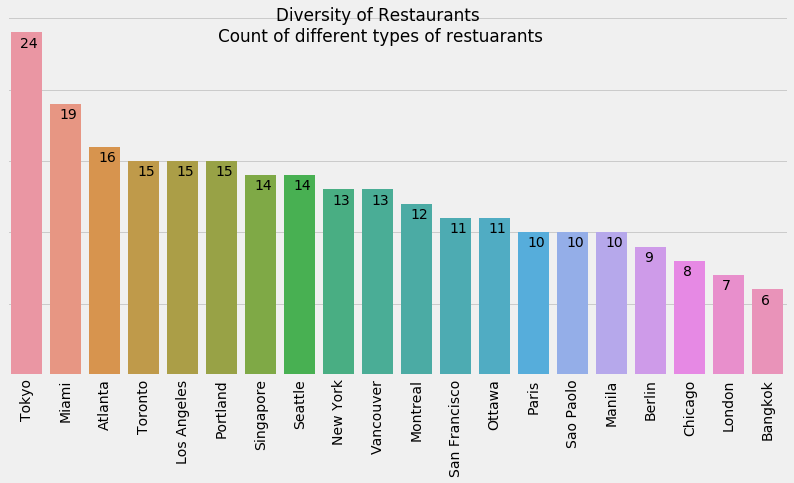

In [55]:
chart_data = pd.melt(grouped, id_vars = ['City'], value_vars = grouped.columns[1:], var_name="Restaurant", value_name='Share')
diversity = chart_data.sort_values('Share', ascending=False)[chart_data['Share']>=0.01]
chart_d = pd.DataFrame(diversity.groupby('City').count()['Share']).sort_values('Share', ascending=False).reset_index()
div = chart_d
c = sns.catplot(x="City", y="Share", data=chart_d, height=6, aspect=2, kind="bar")
c.set_xticklabels(rotation=90)
c.set_ylabels('')
c.set_yticklabels('')
c.set_xlabels('')
c.fig.suptitle("Diversity of Restaurants \nCount of different types of restuarants")
i=0
for index, row in chart_d.iterrows():
    c.ax.text(x=i-.17,y=row['Share']-1, s=row['Share'])
    i=i+1

Tokyo is interesting, but looking at the data, about half (13) of their 24 styles were Japanese. Maybe the Japanese are just very good at specializing. However, it does show that residents of Tokyo have wide ranging tastes.

In [21]:
diversity[diversity['City']=="Tokyo"]

,City,Restaurant,Share
597,Tokyo,Japanese Restaurant,0.125
1157,Tokyo,Sushi Restaurant,0.075
577,Tokyo,Japanese Curry Restaurant,0.075
897,Tokyo,Ramen Restaurant,0.075
1417,Tokyo,Yoshoku Restaurant,0.075
1017,Tokyo,Soba Restaurant,0.050
1077,Tokyo,South Indian Restaurant,0.050
217,Tokyo,Chinese Restaurant,0.050
1337,Tokyo,Udon Restaurant,0.050
837,Tokyo,Okonomiyaki Restaurant,0.025


If I’m starting a restaurant and I want adventurous eaters, Tokyo may be a good place to start. Additionally, I’d look at Miami, Atlanta, Toronto, LA and Portland. A second score I wanted to look at was diversity of restaurant styles that were most popular in cities. For this I filtered on restaurant categories that had more than 10% of the popular restaurants in each city. I did this because I wanted to see which cities had the most diversity in styles that were well frequented.

As you’d expect, when filtering this way, Tokyo is the lowest. This is due to their wide range of food tastes. Berlin, London and Ottawa all have restaurant styles that are both diverse but well entrenched.

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


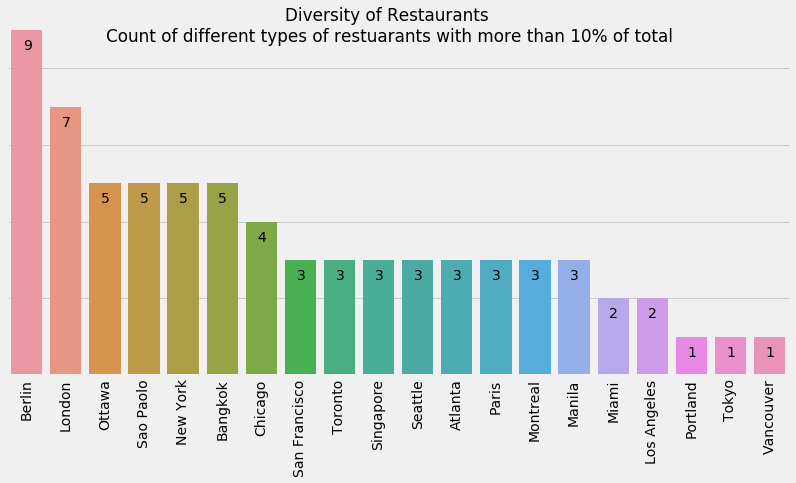

In [26]:
chart_data = pd.melt(grouped, id_vars = ['City'], value_vars = grouped.columns[1:], var_name="Restaurant", value_name='Share')
diversity = chart_data.sort_values('Share', ascending=False)[chart_data['Share']>=0.10]
chart_d = pd.DataFrame(diversity.groupby('City').count()['Share']).sort_values('Share', ascending=False).reset_index()

c = sns.catplot(x="City", y="Share", data=chart_d, height=6, aspect=2, kind="bar")
c.set_xticklabels(rotation=90)
c.set_ylabels('')
c.set_yticklabels('')
c.set_xlabels('')
c.fig.suptitle("Diversity of Restaurants \nCount of different types of restuarants with more than 10% of total")
i=0
for index, row in chart_d.iterrows():
    c.ax.text(x=i-.1,y=row['Share']-.5, s=row['Share'])
    i=i+1

## Results

I then wanted to look at the most popular restaurant style in each city. As expected, Bangkok was Thai, Paris was French cuisine, Sao Paolo was Brazilian. Toronto was ‘Restaurant’, I’m not sure what that style is.

There were some interesting results. Chicago, on the banks of Lake Michigan, was Seafood. Berlin was Italian and Montreal was Vegetarian/Vegan. Atlanta was American and LA was New American (I may need some help understanding the difference). Since this is a sushi face-off, it was nice to see sushi popping up for San Francisco.

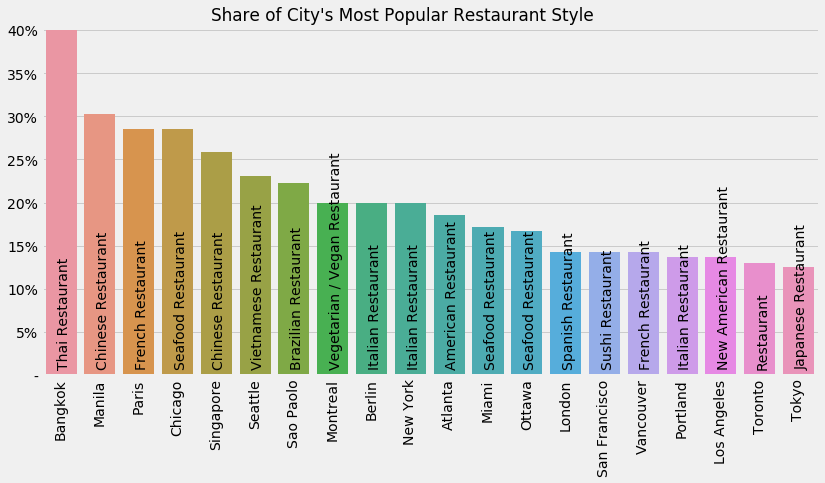

In [27]:
chart_top = diversity.sort_values('Share', ascending=False).drop_duplicates(['City'])
g = sns.catplot(x="City", y="Share", data=chart_top, kind='bar',
                height=6, aspect=2)
g.set_xticklabels(rotation=90)
g.set_yticklabels(['-','5%', '10%', '15%', '20%', '25%','30%','35%', '40%'])
g.set_ylabels('')
g.set_xlabels('')
g.fig.suptitle("Share of City's Most Popular Restaurant Style")
i=0
for index, row in chart_top.iterrows():
    g.ax.text(x=i-.1,y=0.01, s=row['Restaurant'], rotation = 90)
    i=i+1

### Grouping Cities

I wanted to see if there were any similarities in cities using k-means clustering. The data I used was the grouped onehot encoded data that looked at the share of each restaurant. Looking at the elbow chart, a k of 5 looks sufficient as the elbow starts to bend at this point.

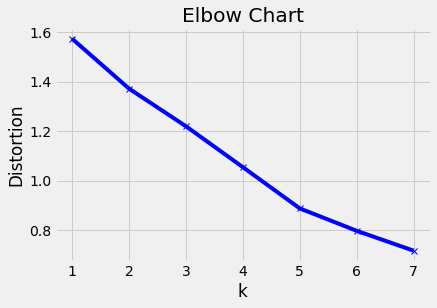

In [47]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize

X = grouped[grouped.columns[1:]]

# k means determine k
distortions = []
K = range(1,8)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Chart')
plt.show()

In [50]:
kmeanModel = KMeans(5).fit(X)
kmeanModel.fit(X)
kmeanModel.labels_
cities.sort_values('City', inplace=True)
cities['Cluster'] = kmeanModel.labels_
cities.reset_index(drop=True, inplace=True)


Mapping these clusters gives an idea of which cities are similar. Canadian cities are mostly in the same group, save for Ottawa, and share this group with Paris, Singapore and Manilla. Bangkok is in a cluster by itself (likely due to its low restaurant diversity). Interestingly, London, Miami and Ottawa all have similar tastes.

In [84]:
map_cities = folium.Map(location=[0,0], zoom_start=2, tiles='CartoDB positron')

colors_array = cm.rainbow(np.linspace(0, 1, 4))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, city, cluster in zip(cities['Latitude'], cities['Longitude'], cities['City'], cities['Cluster']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=6,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_cities) 

map_cities

### Looking at sushi

Now diving into Sushi, the following chart looks at the share of sushi restaurants in each city. There are nine cities that have sushi restaurants that are top venues to visit. London, San Francisco and Los Angeles all have about 14% of their popular restaurants that are sushi restaurants.

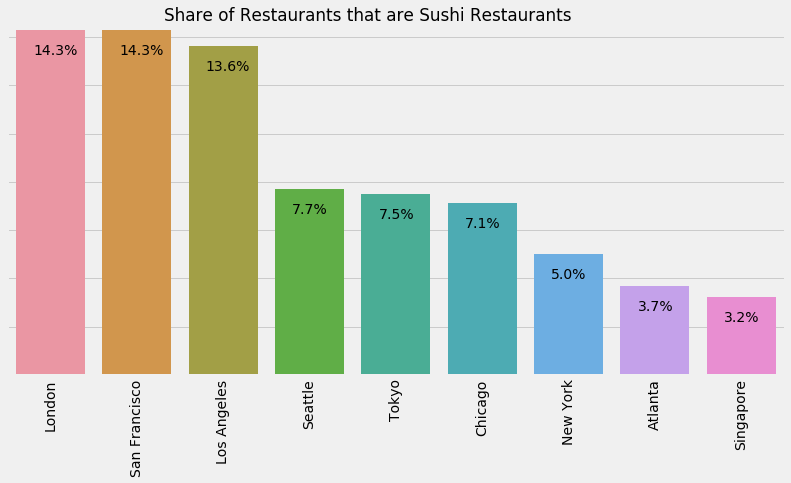

In [68]:
sushi = grouped[['City','Sushi Restaurant']].sort_values('Sushi Restaurant', ascending =False)
sushi = sushi[sushi['Sushi Restaurant'] >0].reset_index(drop=True)

g = sns.catplot(x="City", y="Sushi Restaurant", data=sushi, kind='bar',
                height=6, aspect=2)
g.set_xticklabels(rotation=90)
g.set_yticklabels('')
g.set_ylabels('')
g.set_xlabels('')
g.fig.suptitle("Share of Restaurants that are Sushi Restaurants")
i=0
for index, row in sushi.iterrows():
    g.ax.text(x=i-.2,y=row['Sushi Restaurant']-.01, s=str(round(row['Sushi Restaurant']*100,1))+'%')
    i=i+1

## Discussion

As we’ve seen in the data analysis, choosing a city to open a restaurant depends on residents’ tastes and the popularity of sushi restaurants in the city. Combing the information that’s been presented, the optimal location would be a city with high diversity and an interest in sushi.

Looking at this chart, I would lean towards Los Angeles or San Francisco. The rationale is that these locations have both diversity in taste and an interest in sushi.

(1, 25)

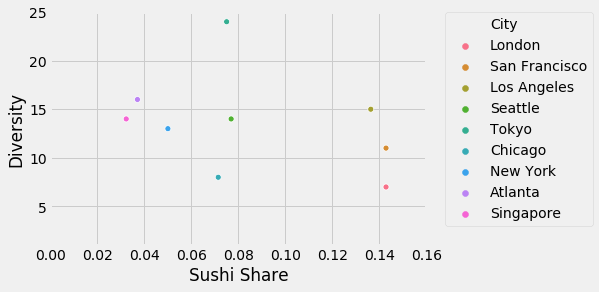

In [83]:
data = sushi.merge(div, on='City')
data.rename(columns={'Share':'Diversity', 'Sushi Restaurant':'Sushi Share'}, inplace=True)
sns.scatterplot(x='Sushi Share', y='Diversity', data=data, hue='City')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim(0,.16)
plt.ylim(1,25)


## Conclusion

FourSquare provides users a way to dive into popular locations in defined geographies to make informed decisions on a range of business problems. As shown in the report, FourSquare can be used to look at the popularity of restaurants, using this data alongside scikit-lean for machine learning, folium for mapping and Seaborn/Matplotlib for exploratory data analysis, there are lots of interesting projects that can be undertaken.